In [5]:
%reload_kedro
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import pickle

import pandas as pd
from textgrader.pipelines.data_processing.config import *

from xgboost import XGBRegressor
from sklearn.metrics import cohen_kappa_score

[10/29/23 16:46:03] INFO     Resolved project path as:                                              ]8;id=513016;file://C:\Users\ramon.boucas\Miniconda3\lib\site-packages\kedro\ipython\__init__.py\__init__.py]8;;\:]8;id=581544;file://C:\Users\ramon.boucas\Miniconda3\lib\site-packages\kedro\ipython\__init__.py#142\142]8;;\
                             C:\Users\ramon.boucas\Desktop\pesquisa_kedro\textgrader.                              
                             To set a different path, run '%reload_kedro <project_root>'                           

[10/29/23 16:46:04] WARNING  C:\Users\ramon.boucas\Miniconda3\lib\site-packages\kedro\io\partitione ]8;id=495351;file://C:\Users\ramon.boucas\Miniconda3\lib\warnings.py\warnings.py]8;;\:]8;id=918331;file://C:\Users\ramon.boucas\Miniconda3\lib\warnings.py#110\110]8;;\
                             d_dataset.py:202: KedroDeprecationWarning: 'PartitionedDataset' has                   
                             been moved to `kedro-datasets` and will be removed in Kedro 0.19.0.                   
                               KedroDeprecationWarning,                                                            
                                                                                                                   

                    INFO     Kedro project textgrader                                               ]8;id=311768;file://C:\Users\ramon.boucas\Miniconda3\lib\site-packages\kedro\ipython\__init__.py\__init__.py]8;;\:]8;id=166135;file://C:\Users\ramon.boucas\Miniconda3\lib\site-packages\kedro\ipython\__init__.py#108\108]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=13084;file://C:\Users\ramon.boucas\Miniconda3\lib\site-packages\kedro\ipython\__init__.py\__init__.py]8;;\:]8;id=179578;file://C:\Users\ramon.boucas\Miniconda3\lib\site-packages\kedro\ipython\__init__.py#110\110]8;;\
                             'pipelines'                                                                           

In [6]:
df_train = catalog.load('primeiro_treino')
df_test = catalog.load('primeiro_teste')

[10/29/23 16:46:06] INFO     Loading data from 'primeiro_treino' (ParquetDataSet)...            ]8;id=745523;file://C:\Users\ramon.boucas\Miniconda3\lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=8626;file://C:\Users\ramon.boucas\Miniconda3\lib\site-packages\kedro\io\data_catalog.py#503\503]8;;\

                    INFO     Loading data from 'primeiro_teste' (ParquetDataSet)...             ]8;id=128407;file://C:\Users\ramon.boucas\Miniconda3\lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=483152;file://C:\Users\ramon.boucas\Miniconda3\lib\site-packages\kedro\io\data_catalog.py#503\503]8;;\

In [9]:
def fit_predict(df):
    
    df_train = df[df['group'] == 'train'].drop(columns = ['group'])
    df_test = df[df['group'] == 'test'].drop(columns = ['group'])
    
    id_train = df_train[ID_VARS]
    X_train = df_train.drop(columns = EXCLUDE_COLS,errors = 'ignore')
    y_train = df_train[TARGETS_1].astype(float)
    
    ## treina o modelo 
    xgb = XGBRegressor()
    fittado = xgb.fit(X_train, y_train)
    
    id_test = df_test[ID_VARS]
    X_test = df_test.drop(columns = EXCLUDE_COLS,errors = 'ignore')
    y_test = df_test[TARGETS_1].astype(float)
   
    PRED_COLS = [col + f'_pred' for col in TARGETS_1]
    
    preds = pd.DataFrame()
    preds[ID_VARS] = id_test
    preds[PRED_COLS] =  xgb.predict(X_test)
    preds[PRED_COLS] = preds[PRED_COLS].astype(int)

    return preds

In [10]:
def fit_predict_both_ways(df_train,df_test):
    df_train['group'] = 'train'
    df_test['group'] = 'test'
    df = pd.concat([df_train,df_test])
    df = df.drop(columns = 'texto',errors = 'ignore')
    pred1 = df.groupby(['tema']).apply(lambda x: fit_predict(x)).reset_index(drop = True)
    pred2 = fit_predict(df)
    
    return [pred1,pred2]

,index,tema,conjunto,Domínio da modalidade escrita formal_nota_pred,Compreender a proposta e aplicar conceitos das várias áreas de conhecimento para desenvolver o texto dissertativo-argumentativo em prosa_nota_pred,"Selecionar, relacionar, organizar e interpretar informações em defesa de um ponto de vista_nota_pred",Conhecimento dos mecanismos linguísticos necessários para a construção da argumentação_nota_pred,Proposta de intervenção com respeito aos direitos humanos_nota_pred
0,0,1,1,134,141,143,146,98
1,36,1,1,158,130,106,167,170
2,35,1,1,157,166,158,181,178
3,104,1,1,151,177,125,194,101
4,65,1,1,133,160,128,165,100
...,...,...,...,...,...,...,...,...
1519,20,85,1,155,181,127,191,170
1520,21,85,1,138,168,156,193,147
1521,18,85,1,129,151,122,156,134
1522,49,85,1,138,182,135,170,178


In [12]:
pred2 = fit_predict(df)
pred2

,index,tema,conjunto,Domínio da modalidade escrita formal_nota_pred,Compreender a proposta e aplicar conceitos das várias áreas de conhecimento para desenvolver o texto dissertativo-argumentativo em prosa_nota_pred,"Selecionar, relacionar, organizar e interpretar informações em defesa de um ponto de vista_nota_pred",Conhecimento dos mecanismos linguísticos necessários para a construção da argumentação_nota_pred,Proposta de intervenção com respeito aos direitos humanos_nota_pred
0,17,78,1,141,144,122,178,129
2,1,77,1,151,155,122,184,129
3,58,83,1,146,157,132,188,143
4,48,8,1,137,136,104,183,106
5,43,51,1,157,144,82,166,109
...,...,...,...,...,...,...,...,...
3392,29,65,1,145,144,146,150,132
3394,15,18,1,157,156,135,185,136
3395,4,70,1,141,159,109,164,128
3397,2,69,1,159,133,104,186,123


In [ ]:
df_train['group'] = 'train'
df_test['group'] = 'test'
df = pd.concat([df_train,df_test])
df = df.drop(columns = 'texto',errors = 'ignore')
pred1 = df.groupby(['tema']).apply(lambda x: fit_predict(x)).reset_index(drop = True)

In [3]:
#pred1 = df.groupby(['tema']).apply(lambda x: fit_predict(x)).reset_index(drop = True)

df_train['group'] = 'train'
df_test['group'] = 'test'
df = pd.concat([df_train,df_test])
df = df.drop(columns = 'texto',errors = 'ignore')
#pred1 = df.groupby(['tema']).apply(lambda x: fit_predict(x)).reset_index(drop = True)
 


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 #pred1 = df.groupby(['tema']).apply(lambda x: fit_predict(x)).reset_index(drop = True)       │
│ ❱ 2 pred2 = fit_predict(df,mode = 'GERAL')                                                       │
│   3 pred2                                                                                        │
│   4                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'df' is not defined

In [20]:
preds = pd.merge(pred1,pred2, on = ['index','tema','conjunto'])
df_geral = pd.merge(df_test,preds,  on = ['index','tema','conjunto'])
df_geral

,index,tema,id,conjunto,Domínio da modalidade escrita formal_nota,Compreender a proposta e aplicar conceitos das várias áreas de conhecimento para desenvolver o texto dissertativo-argumentativo em prosa_nota,"Selecionar, relacionar, organizar e interpretar informações em defesa de um ponto de vista_nota",Conhecimento dos mecanismos linguísticos necessários para a construção da argumentação_nota,Proposta de intervenção com respeito aos direitos humanos_nota,word_count,...,Domínio da modalidade escrita formal_nota_pred_ESPECIFICO,Compreender a proposta e aplicar conceitos das várias áreas de conhecimento para desenvolver o texto dissertativo-argumentativo em prosa_nota_pred_ESPECIFICO,"Selecionar, relacionar, organizar e interpretar informações em defesa de um ponto de vista_nota_pred_ESPECIFICO",Conhecimento dos mecanismos linguísticos necessários para a construção da argumentação_nota_pred_ESPECIFICO,Proposta de intervenção com respeito aos direitos humanos_nota_pred_ESPECIFICO,Domínio da modalidade escrita formal_nota_pred_GERAL,Compreender a proposta e aplicar conceitos das várias áreas de conhecimento para desenvolver o texto dissertativo-argumentativo em prosa_nota_pred_GERAL,"Selecionar, relacionar, organizar e interpretar informações em defesa de um ponto de vista_nota_pred_GERAL",Conhecimento dos mecanismos linguísticos necessários para a construção da argumentação_nota_pred_GERAL,Proposta de intervenção com respeito aos direitos humanos_nota_pred_GERAL
0,17,78,12273,1,120.0,80.0,80.0,120.0,80.0,409,...,146,159,119,182,165,141,144,122,178,129
1,1,77,12357,1,160.0,40.0,40.0,120.0,0.0,423,...,159,123,112,197,180,151,155,122,184,129
2,58,83,11738,1,160.0,120.0,80.0,160.0,120.0,383,...,179,135,111,168,130,146,157,132,188,143
3,48,8,19157,1,120.0,120.0,120.0,160.0,120.0,252,...,151,155,118,162,131,137,136,104,183,106
4,43,51,14464,1,160.0,120.0,120.0,160.0,120.0,297,...,127,94,116,110,88,157,144,82,166,109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1519,29,65,13387,1,120.0,120.0,80.0,120.0,120.0,260,...,144,170,132,155,168,145,144,146,150,132
1520,15,18,18114,1,120.0,40.0,40.0,120.0,40.0,338,...,155,162,108,181,144,157,156,135,185,136
1521,4,70,13082,1,160.0,160.0,120.0,200.0,160.0,340,...,158,179,143,198,191,141,159,109,164,128
1522,2,69,13140,1,160.0,200.0,160.0,200.0,200.0,429,...,154,119,123,175,134,159,133,104,186,123


In [21]:
df_geral

,index,tema,id,conjunto,Domínio da modalidade escrita formal_nota,Compreender a proposta e aplicar conceitos das várias áreas de conhecimento para desenvolver o texto dissertativo-argumentativo em prosa_nota,"Selecionar, relacionar, organizar e interpretar informações em defesa de um ponto de vista_nota",Conhecimento dos mecanismos linguísticos necessários para a construção da argumentação_nota,Proposta de intervenção com respeito aos direitos humanos_nota,word_count,...,Domínio da modalidade escrita formal_nota_pred_ESPECIFICO,Compreender a proposta e aplicar conceitos das várias áreas de conhecimento para desenvolver o texto dissertativo-argumentativo em prosa_nota_pred_ESPECIFICO,"Selecionar, relacionar, organizar e interpretar informações em defesa de um ponto de vista_nota_pred_ESPECIFICO",Conhecimento dos mecanismos linguísticos necessários para a construção da argumentação_nota_pred_ESPECIFICO,Proposta de intervenção com respeito aos direitos humanos_nota_pred_ESPECIFICO,Domínio da modalidade escrita formal_nota_pred_GERAL,Compreender a proposta e aplicar conceitos das várias áreas de conhecimento para desenvolver o texto dissertativo-argumentativo em prosa_nota_pred_GERAL,"Selecionar, relacionar, organizar e interpretar informações em defesa de um ponto de vista_nota_pred_GERAL",Conhecimento dos mecanismos linguísticos necessários para a construção da argumentação_nota_pred_GERAL,Proposta de intervenção com respeito aos direitos humanos_nota_pred_GERAL
0,17,78,12273,1,120.0,80.0,80.0,120.0,80.0,409,...,146,159,119,182,165,141,144,122,178,129
1,1,77,12357,1,160.0,40.0,40.0,120.0,0.0,423,...,159,123,112,197,180,151,155,122,184,129
2,58,83,11738,1,160.0,120.0,80.0,160.0,120.0,383,...,179,135,111,168,130,146,157,132,188,143
3,48,8,19157,1,120.0,120.0,120.0,160.0,120.0,252,...,151,155,118,162,131,137,136,104,183,106
4,43,51,14464,1,160.0,120.0,120.0,160.0,120.0,297,...,127,94,116,110,88,157,144,82,166,109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1519,29,65,13387,1,120.0,120.0,80.0,120.0,120.0,260,...,144,170,132,155,168,145,144,146,150,132
1520,15,18,18114,1,120.0,40.0,40.0,120.0,40.0,338,...,155,162,108,181,144,157,156,135,185,136
1521,4,70,13082,1,160.0,160.0,120.0,200.0,160.0,340,...,158,179,143,198,191,141,159,109,164,128
1522,2,69,13140,1,160.0,200.0,160.0,200.0,200.0,429,...,154,119,123,175,134,159,133,104,186,123


In [18]:
df_gersl

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 df_gersl                                                                                     │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'df_gersl' is not defined

In [22]:
for target in TARGETS_1:
    print(target)
    a = cohen_kappa_score(df_geral[target].astype(int),df_geral[f"{target}_pred_ESPECIFICO"],weights = 'quadratic')
    b = cohen_kappa_score(df_geral[target].astype(int),df_geral[f"{target}_pred_GERAL"], weights = 'quadratic')

    print(a) 
    print(b)

Domínio da modalidade escrita formal_nota
-0.03683835659579748
0.016961443384690522
Compreender a proposta e aplicar conceitos das várias áreas de conhecimento para desenvolver o texto dissertativo-argumentativo em prosa_nota
-0.014913208053719318
-0.014314876447031555
Selecionar, relacionar, organizar e interpretar informações em defesa de um ponto de vista_nota
0.02935402532663456
-0.01124593848165567
Conhecimento dos mecanismos linguísticos necessários para a construção da argumentação_nota
-0.0032214694575032343
-0.03186705732063966
Proposta de intervenção com respeito aos direitos humanos_nota
-0.028980482660291962
-0.002349858210547895


<Axes: xlabel='unique_word_count', ylabel='Domínio da modalidade escrita formal_nota'>

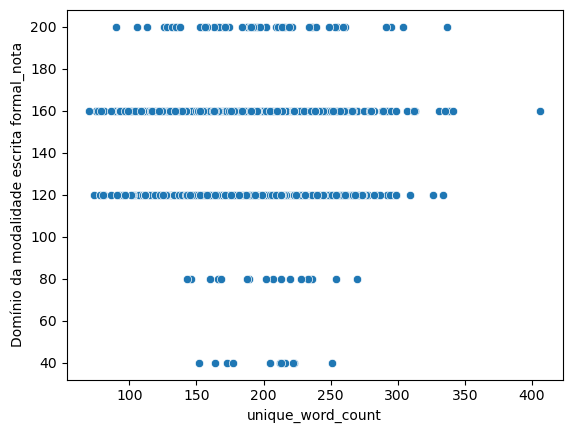

In [30]:
import seaborn as sns

sns.scatterplot(data = df_geral , x ='unique_word_count', y = 'Domínio da modalidade escrita formal_nota')

In [25]:
df

,index,tema,conjunto,Domínio da modalidade escrita formal_nota,Compreender a proposta e aplicar conceitos das várias áreas de conhecimento para desenvolver o texto dissertativo-argumentativo em prosa_nota,"Selecionar, relacionar, organizar e interpretar informações em defesa de um ponto de vista_nota",Conhecimento dos mecanismos linguísticos necessários para a construção da argumentação_nota,Proposta de intervenção com respeito aos direitos humanos_nota,Adequação ao Tema_nota,Adequação e Leitura Crítica da Coletânea_nota,...,tem,ter,todos,um,uma,vez,vida,violência,vírgula,group
0,2880,29,1,120.0,120.0,120.0,160.0,120.0,NaN,NaN,...,0.060225,0.000000,0.000000,0.071829,0.216222,0.000000,0.000000,0.000000,0.0,train
1,6201,71,1,160.0,120.0,80.0,200.0,80.0,NaN,NaN,...,0.075142,0.000000,0.000000,0.134430,0.000000,0.000000,0.000000,0.000000,0.0,train
2,5726,63,1,120.0,160.0,120.0,200.0,200.0,NaN,NaN,...,0.000000,0.000000,0.098281,0.215261,0.053999,0.000000,0.000000,0.134379,0.0,train
6,4987,51,1,160.0,120.0,120.0,160.0,120.0,NaN,NaN,...,0.000000,0.000000,0.059386,0.097553,0.163142,0.063798,0.000000,0.081198,0.0,train
7,5693,62,1,160.0,160.0,120.0,200.0,120.0,NaN,NaN,...,0.000000,0.000000,0.206522,0.056542,0.056735,0.000000,0.000000,0.141187,0.0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3392,5824,65,1,120.0,120.0,80.0,120.0,120.0,NaN,NaN,...,0.288460,0.000000,0.000000,0.043005,0.129454,0.084373,0.082329,0.000000,0.0,test
3394,1613,18,1,120.0,40.0,40.0,120.0,40.0,NaN,NaN,...,0.000000,0.161302,0.070284,0.115455,0.231697,0.075506,0.073676,0.000000,0.0,test
3395,6051,70,1,160.0,160.0,120.0,200.0,160.0,NaN,NaN,...,0.000000,0.000000,0.000000,0.120710,0.211963,0.000000,0.057772,0.000000,0.0,test
3397,5956,69,1,160.0,200.0,160.0,200.0,200.0,NaN,NaN,...,0.056551,0.000000,0.000000,0.033723,0.135353,0.000000,0.000000,0.000000,0.0,test


In [ ]:
import seaborn as sns

sns.scatterplot(data = df , x ='word_count', y = 'Domínio da modalidade escrita formal_nota')

In [ ]:
for target in TARGETS_1:
    print(target)
    a = cohen_kappa_score(df_geral[target].astype(int),df_geral[f"{target}_pred_ESPECIFICO"],weights = 'quadratic')
    b = cohen_kappa_score(df_geral[target].astype(int),df_geral[f"{target}_pred_GERAL"], weights = 'quadratic')

    print(a) 
    print(b)

In [5]:
from nltk.tokenize import sent_tokenize, word_tokenize


tok = word_tokenize("comprei uma galinha d'angola",language = 'portuguese')
tok 

['comprei', 'uma', 'galinha', "d'angola"]

In [14]:
import nltk

# baixa as stopwords
nltk.download('stopwords')
 
 

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [15]:
# para escolher as stopwords do português adicionamos a opçaõ de língua "portuguese"
stopwords = nltk.corpus.stopwords.words('portuguese')
stopwords

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - 'C:\\Users\\ramon.boucas/nltk_data'
    - 'C:\\ProgramData\\anaconda3\\nltk_data'
    - 'C:\\ProgramData\\anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\ramon.boucas\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************
